# Developing "Momentum" Trading Strategy
* Many differnt takes on this strategy
* Sometimes referred to as trend following
* Whatever you do and call it, you first need to research potential trading signals

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt


### 1. Download data: 
* Many services for this, some paid some free 
* Yahoo Finance API
* Typically trading "systems" involve a number of securities
* For this demonstration we are just going to look at GLD --> the gold ETF

In [30]:
result = pd.read_csv(r'E:\Data_Stock\excel_gvr.csv')
result["Date"] = pd.to_datetime(result["<DTYYYYMMDD>"], format='%Y%m%d')
result['Open'] = pd.to_numeric(result['<OpenFixed>'].astype(str)) * 1000
result['Close'] = pd.to_numeric(result['<CloseFixed>'].astype(str)) * 1000
result['High'] = pd.to_numeric(result['<HighFixed>'].astype(str)) * 1000
result['Low'] = pd.to_numeric(result['<LowFixed>'].astype(str)) * 1000
result['Volume'] = pd.to_numeric(result['<Volume>'].astype(str))
gld = result[['Date','Open','High','Low' ,'Close','Volume']].copy()
gld.head()

,Date,Open,High,Low,Close,Volume
0,2018-03-21,13500.3,13500.3,8820.2,9810.2,515800
1,2018-03-22,9900.2,10170.2,9180.2,9810.2,260800
2,2018-03-23,9540.2,9540.2,9000.2,9450.2,111800
3,2018-03-26,9180.2,9450.2,9180.2,9270.2,267800
4,2018-03-27,9720.2,9900.2,9450.2,9810.2,52200


In [31]:
gld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1192 non-null   datetime64[ns]
 1   Open    1192 non-null   float64       
 2   High    1192 non-null   float64       
 3   Low     1192 non-null   float64       
 4   Close   1192 non-null   float64       
 5   Volume  1192 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 56.0 KB


### 2. Add data/transform data
* calculate signal based on some price or statistical action
* we are going to try a moving average crossover to generate signals
* for this strategy we will always by "in" a trade, either long or short
* we are modeling; this means real life variation should be expected

#### Add moving averages to the data frame

In [32]:
gld['9-day'] = gld['Close'].rolling(9).mean()
gld['21-day'] = gld['Close'].rolling(21).mean()
gld[19:25]

,Date,Open,High,Low,Close,Volume,9-day,21-day
19,2018-04-17,9360.2,9720.2,9360.2,9720.2,159800,9770.2,NaN
20,2018-04-18,9720.2,9810.2,9540.2,9630.2,83800,9710.2,10075.914286
21,2018-04-19,9540.2,9630.2,9360.2,9630.2,165400,9670.2,10067.342857
22,2018-04-20,9540.2,9630.2,9360.2,9540.2,76100,9650.2,10054.485714
23,2018-04-23,9540.2,9540.2,9180.2,9540.2,211500,9600.2,10058.771429
24,2018-04-24,9000.2,9360.2,9000.2,9270.2,21100,9570.2,10058.771429


#### Add "signal" column  

In [33]:
gld['signal'] = np.where(gld['9-day'] > gld['21-day'], 1, 0)
gld['signal'] = np.where(gld['9-day'] < gld['21-day'], -1, gld['signal'])
gld.dropna(inplace=True)
gld.head()

,Date,Open,High,Low,Close,Volume,9-day,21-day,signal
20,2018-04-18,9720.2,9810.2,9540.2,9630.2,83800,9710.2,10075.914286,-1
21,2018-04-19,9540.2,9630.2,9360.2,9630.2,165400,9670.2,10067.342857,-1
22,2018-04-20,9540.2,9630.2,9360.2,9540.2,76100,9650.2,10054.485714,-1
23,2018-04-23,9540.2,9540.2,9180.2,9540.2,211500,9600.2,10058.771429,-1
24,2018-04-24,9000.2,9360.2,9000.2,9270.2,21100,9570.2,10058.771429,-1


#### Calculate Instantaneous returns/system returns

In [34]:
gld['return'] = np.log(gld['Close']).diff()
gld['system_return'] = gld['signal'] * gld['return']
gld['entry'] = gld.signal.diff()
gld.head()

,Date,Open,High,Low,Close,Volume,9-day,21-day,signal,return,system_return,entry
20,2018-04-18,9720.2,9810.2,9540.2,9630.2,83800,9710.2,10075.914286,-1,NaN,NaN,NaN
21,2018-04-19,9540.2,9630.2,9360.2,9630.2,165400,9670.2,10067.342857,-1,0.000000,-0.000000,0.0
22,2018-04-20,9540.2,9630.2,9360.2,9540.2,76100,9650.2,10054.485714,-1,-0.009390,0.009390,0.0
23,2018-04-23,9540.2,9540.2,9180.2,9540.2,211500,9600.2,10058.771429,-1,0.000000,-0.000000,0.0
24,2018-04-24,9000.2,9360.2,9000.2,9270.2,21100,9570.2,10058.771429,-1,-0.028709,0.028709,0.0


#### Plot trades on time series

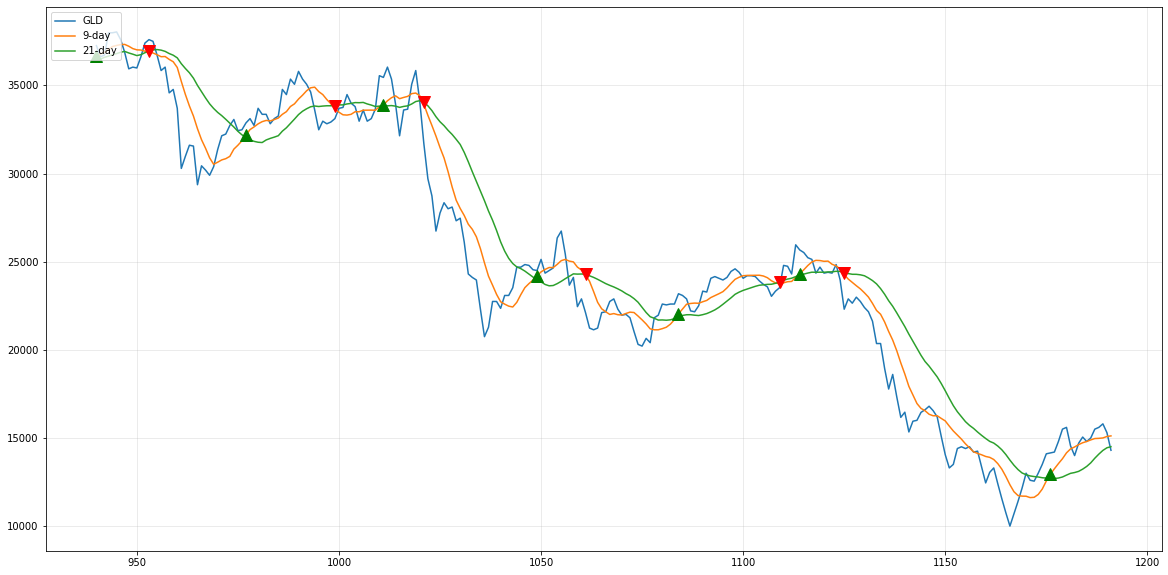

In [35]:
plt.rcParams['figure.figsize'] = 20, 10
plt.grid(True, alpha = .3)
plt.plot(gld.iloc[-252:]['Close'], label = 'GLD')
plt.plot(gld.iloc[-252:]['9-day'], label = '9-day')
plt.plot(gld.iloc[-252:]['21-day'], label = '21-day')
plt.plot(gld[-252:].loc[gld.entry == 2].index, gld[-252:]['9-day'][gld.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(gld[-252:].loc[gld.entry == -2].index, gld[-252:]['21-day'][gld.entry == -2], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2)

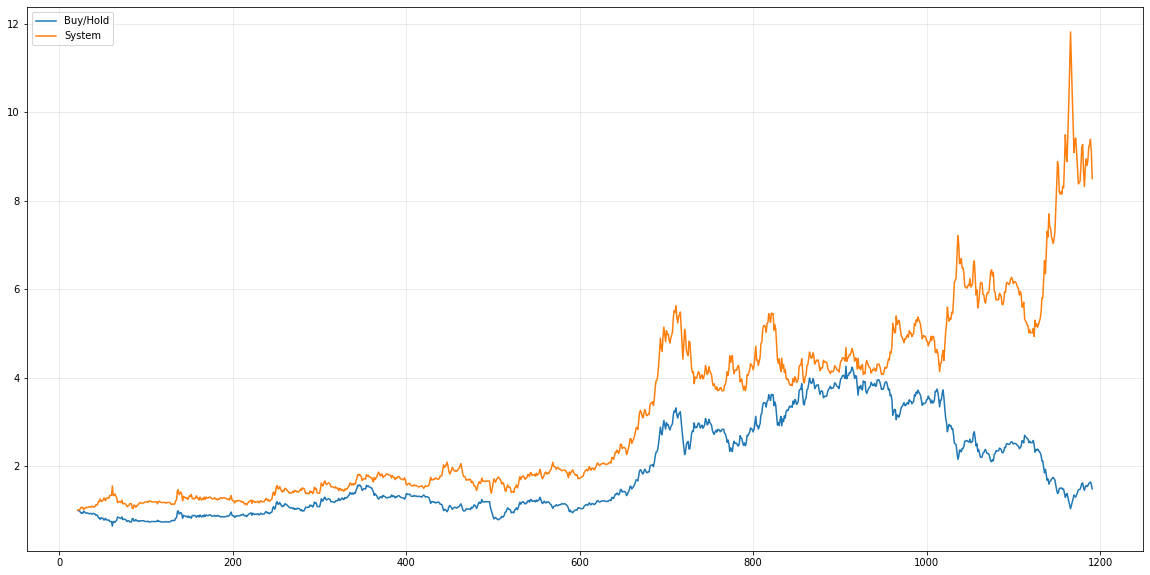

In [36]:
plt.plot(np.exp(gld['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)